In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import matplotlib as mpl

# --- Global plotting style ---
mpl.rcParams.update(
    {
        "font.family": "Times New Roman",  # or "Times New Roman" / "Arial" if you prefer
        "font.size": 12,
        "axes.titlesize": 10,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
    }
)


FIGSIZE = (6, 4)   # common figure size
DPI = 600    # higher DPI for publication quality


model_name_map = {
    'deepconvnet': 'DeepConvNet',
    'labram_last_8': 'LaBraM–PartialFT',  # U+2013 en-dash
    'labram-lora': 'LaBraM–LoRA'
}

# Colorblind-friendly palette (Wong palette + adjustments)
model_colors = {
    "deepconvnet": "#0072B2",   # blue (safe for all types)
    "labram_last_8": "#E69F00", # orange/amber (safe for all types)
    "labram-lora": "#CC79A7",   # pink/magenta (safe for all types)
}

# Define markers for each model
markers = {
    'deepconvnet': 'o',
    'labram_last_8': 's',
    'labram-lora': '^'
}

# Consistent plot order: deepconvnet, labram_last_8 (PartialFT), labram-lora (LoRA)
plot_order = ['deepconvnet', 'labram_last_8', 'labram-lora']
model_order = ['deepconvnet', 'labram_last_8', 'labram-lora']

In [26]:
df_csv = pd.read_csv('out.csv')


print(df_csv.columns)
print(df_csv.shape)
print(df_csv['model'].unique())

Index(['Unnamed: 0', 'subject_id', 'shots', 'repetition', 'final_accuracy',
       'final_loss', 'final_accuracy_train', 'n_samples', 'n_support',
       'n_query',
       ...
       'epoch_time_e13', 'epoch_time_e14', 'epoch_time_e15', 'epoch_time_e16',
       'epoch_time_e17', 'epoch_time_e18', 'epoch_time_e19', 'epoch_time_e20',
       'model', 'experiment'],
      dtype='object', length=120)
(22680, 120)
['labram_last_8' 'deepconvnet' 'labram-lora']


In [27]:
ID_VARS = ['subject_id', 'model', 'experiment', 'shots', 'repetition', 'n_support', 'n_query']

EPOCHS = 20
# metric: split
# accuracy: train 
df_train = df_csv.melt(
    id_vars=ID_VARS,
    value_vars=[f'acc_train_e{i}' for i in range(1, EPOCHS+1)],
    var_name='epoch',
    value_name='value'
)
df_train['split'] = 'train'
df_train['metric'] = 'accuracy'

# accuracy: test 
df_test = df_csv.melt(
    id_vars=ID_VARS,
    value_vars=[f'acc_test_e{i}' for i in range(1, EPOCHS+1)],
    var_name='epoch',
    value_name='value'
)
df_test['split'] = 'test'
df_test['metric'] = 'accuracy'

# loss: support 
df_supp = df_csv.melt(
    id_vars=ID_VARS,
    value_vars=[f'loss_supp_e{i}' for i in range(1, EPOCHS+1)],
    var_name='epoch',
    value_name='value'
)
df_supp['split'] = 'support'
df_supp['metric'] = 'loss'

# loss: query 
df_query = df_csv.melt(
    id_vars=ID_VARS,
    value_vars=[f'loss_q_e{i}' for i in range(1, EPOCHS+1)],
    var_name='epoch',
    value_name='value'
)
df_query['split'] = 'query'
df_query['metric'] = 'loss'

# combine
df_long = pd.concat([df_train, df_test, df_supp, df_query], ignore_index=True)
# clean epoch
df_long['epoch'] = df_long['epoch'].str.extract(r'e(\d+)').astype(int)

# reorder
df = df_long[ID_VARS + ['epoch', 'split', 'metric', 'value']].sort_values(ID_VARS + ['metric','split','epoch']).reset_index(drop=True)

print(f"Shape: {df.shape}")

print("Unique values:")
for col in ID_VARS:
    unique_vals = df[col].unique()
    n_unique = len(unique_vals)
    preview = ", ".join(map(str, unique_vals[:10]))
    print(f"  {col:<12}: {n_unique:>3} unique --> {preview}")
print(f"Splits: {df['split'].unique().tolist()}")
print(f"Metrics: {df['metric'].unique().tolist()}")
print(df.columns)
print(df.head())


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 1) Define per-model rules (examples based on your three dicts)
rules = {
    "deepconvnet": {0: 1, 1: 1, 2: 1, 3: 2, 4: 2, 5: 13, 6: 15, 7: 13, 8: 15, 9: 14, 10: 12, 25: 15},
    "labram-lora": {0: 1, 1: 5, 2: 7, 3: 8, 4: 10, 5: 12, 6: 14, 7: 15, 8: 17, 9: 20, 10: 20, 25: 20},
    "labram_last_8": {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 25: 20},
}

def plot_rule_based_epochs_by_model(df, rules, outfile="img/rule_based_accuracy.jpg", show=True):
    # 2) Filter to test accuracy and coerce numerics (helps with merges/sorting)
    df_acc = df[(df['split'] == 'test') & (df['metric'] == 'accuracy')].copy()
    df_acc['shots'] = pd.to_numeric(df_acc['shots'], errors='coerce')
    df_acc['epoch'] = pd.to_numeric(df_acc['epoch'], errors='coerce')

    # 3) Average over repetitions first
    df_mean_rep = (
        df_acc
        .groupby(['subject_id', 'model', 'shots', 'epoch'], as_index=False)['value']
        .mean()
    )

    # 4) Build a rule table and inner-merge to pick the desired rows
    rows = []
    for m, d in rules.items():
        for s, e in d.items():
            rows.append({"model": m, "shots": s, "epoch": e})
    rule_df = pd.DataFrame(rows)

    # Only keep models actually present (avoids empty merges if a rule names a missing model)
    present_models = df_mean_rep['model'].unique()
    rule_df = rule_df[rule_df['model'].isin(present_models)].copy()

    df_selected = df_mean_rep.merge(rule_df, on=['model', 'shots', 'epoch'], how='inner')

    print(df_selected.head())

    # 5) Aggregate across subjects (mean ± std per model and shots)
    summary = (
        df_selected
        .groupby(['shots', 'model'])['value']
        .agg(mean='mean', std='std', n='count')
        .reset_index()
        .sort_values(['model', 'shots'])
    )

    # # 6) Plot
    # plt.figure(figsize=FIGSIZE)
    # for model, g in summary.groupby('model'):
    #     g = g.sort_values('shots')
    #     plt.errorbar(
    #         g['shots'], g['mean'], yerr=g['std'],
    #         label=model_name_map.get(model, model),
    #         capsize=3,
    #         marker='o',
    #         linestyle='-',
    #         color=model_colors.get(model, None),
    #     )

    # plt.xlabel('Shots')
    # plt.ylabel('Accuracy')
    # # plt.title('Mean ± SD accuracy across subjects (rule-based epoch per model/shot)')
    # plt.grid(True, linestyle='--', alpha=0.4)
    # plt.legend(title='Model')
    # plt.tight_layout()
    # plt.savefig(outfile, dpi=DPI, bbox_inches='tight')
    # if show:
    #     plt.show()
    # else:
    #     plt.close()

    return summary, df_selected
summary, df_selected = plot_rule_based_epochs_by_model(df, rules)


Shape: (1814400, 11)
Unique values:
  subject_id  :  54 unique --> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
  model       :   3 unique --> deepconvnet, labram-lora, labram_last_8
  experiment  : 108 unique --> deepconvnet_lomso_fold001_test1, labram_lomso_fold001_test1, deepconvnet_lomso_fold002_test2, labram_lomso_fold002_test2, deepconvnet_lomso_fold003_test3, labram_lomso_fold003_test3, deepconvnet_lomso_fold004_test4, labram_lomso_fold004_test4, deepconvnet_lomso_fold005_test5, labram_lomso_fold005_test5
  shots       :  14 unique --> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
  repetition  :  10 unique --> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
  n_support   :  14 unique --> 0, 2, 4, 6, 8, 10, 12, 14, 16, 18
  n_query     :  14 unique --> 400, 398, 396, 394, 392, 390, 388, 386, 384, 382
Splits: ['test', 'train', 'query', 'support']
Metrics: ['accuracy', 'loss']
Index(['subject_id', 'model', 'experiment', 'shots', 'repetition', 'n_support',
       'n_query', 'epoch', 'split', 'metric', 'value'],
      dtype='object'

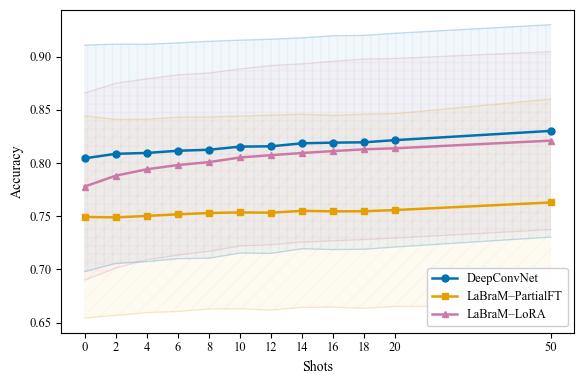

In [28]:
# --- Same plot but with shaded SD regions instead of error bars ---

# TUNABLE: opacity of the shaded SD region and edge line width
SD_ALPHA = 0.05
EDGE_LINEWIDTH = 1.0
EDGE_ALPHA = 0.2

# Different hatch patterns for each model
model_hatches = {
    "deepconvnet": "||",  # no hatch (solid)
    "labram_last_8": "//",  # diagonal lines
    "labram-lora": "--",  # dots
}

# Apply nonlinear remapping to compress space between 20 and 50
def squash_shots(x):
    x = np.array(x, dtype=float)
    return np.where(x > 10, 10 + (x - 10) / 3, x)  # compress anything >10

plt.figure(figsize=FIGSIZE)

for model in plot_order:
    g = summary[summary["model"] == model].sort_values("shots")
    x = squash_shots(g["shots"].values)
    y = g["mean"].values
    std = g["std"].values
    color = model_colors.get(model, None)
    hatch = model_hatches.get(model, '')
    
    # Plot shaded SD region with hatch pattern
    plt.fill_between(
        x, 
        y - std, 
        y + std, 
        alpha=SD_ALPHA, 
        color=color,
        hatch=hatch,
        edgecolor=color,
        linewidth=0.5
    )
    
    # Plot edge lines for SD bounds
    plt.plot(x, y - std, color=color, linewidth=EDGE_LINEWIDTH, alpha=EDGE_ALPHA, linestyle='-')
    plt.plot(x, y + std, color=color, linewidth=EDGE_LINEWIDTH, alpha=EDGE_ALPHA, linestyle='-')
    
    # Plot mean line with markers
    plt.plot(
        x, y,
        label=model_name_map.get(model, model),
        marker=markers.get(model, "o"),
        linestyle="-",
        color=color,
        linewidth=1.8,
        markersize=5
    )

plt.xlabel("Shots")
plt.ylabel("Accuracy")

# Set x-axis ticks to show doubled values
shot_values = sorted(summary["shots"].unique())
ticks = squash_shots(shot_values)
plt.xticks(ticks, [int(x * 2) for x in shot_values])

plt.legend(loc="lower right", frameon=True, framealpha=0.95)
plt.tight_layout()
plt.savefig("img/rule_based_accuracy_shaded.jpg", dpi=DPI, bbox_inches="tight")
plt.show()

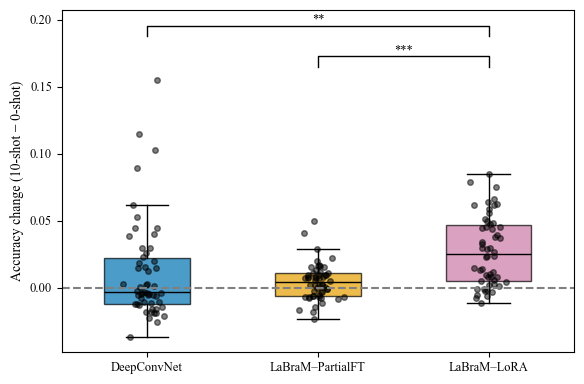

Friedman test on Δ(0→10): χ²(2)=23.593, p=7.53e-06, Kendall's W=0.218

Post-hoc Wilcoxon (Holm-corrected) on Δ(0→10):
deepconvnet vs labram_last_8: W=727.0, p_raw=0.894, p_Holm=0.894, reject=False
deepconvnet vs labram-lora: W=391.0, p_raw=0.00247, p_Holm=0.00495, reject=True
labram_last_8 vs labram-lora: W=133.0, p_raw=1.54e-07, p_Holm=4.61e-07, reject=True

Median Δ(0→10) with bootstrap 95% CIs:
deepconvnet    : median=-0.0036  95% CI=(-0.0058,0.0124)
labram_last_8  : median=0.0038  95% CI=(-0.0005,0.0078)
labram-lora    : median=0.0251  95% CI=(0.0115,0.0359)


In [29]:
# --- Prep ---
df_stats = df_selected.copy()

# consistent model order for plots/tables
model_order = ['deepconvnet', 'labram_last_8', 'labram-lora']

# pivot to wide per subject/model
pivot = (df_stats.pivot_table(index=['subject_id', 'model'], columns='shots', values='value')
           .rename(columns=lambda c: f"N{int(c)}")
         )

# sanity-check required columns
required = ['N0','N5','N25']
missing = [c for c in required if c not in pivot.columns]
if missing:
    raise ValueError(f"Missing columns in pivot: {missing}. Did you compute shots=[0,...,10,...,50]?")

# deltas (FIX: use N25-N5, not N25-N5)
pivot['Δ0→10'] = pivot['N5'] - pivot['N0']
pivot['Δ10→50'] = pivot['N25'] - pivot['N5']
pivot = pivot.reset_index()

# --- Statistical tests first (need results for plotting) ---
from scipy.stats import friedmanchisquare, wilcoxon

acc_diff = pivot.pivot(index='subject_id', columns='model', values='Δ0→10')
acc_diff = acc_diff[model_order]  # ensure consistent order

# Friedman test
chi2, p_friedman = friedmanchisquare(*[acc_diff[m].values for m in model_order])
n = acc_diff.shape[0]
k = acc_diff.shape[1]
kendalls_W = chi2 / (n * (k - 1))

# Post-hoc paired Wilcoxon with Holm correction
pairs = [
    ('deepconvnet', 'labram_last_8'),
    ('deepconvnet', 'labram-lora'),
    ('labram_last_8', 'labram-lora'),
]
raw_ps = []
stats_W = []

for a, b in pairs:
    W, p = wilcoxon(acc_diff[a], acc_diff[b], zero_method='wilcox', alternative='two-sided')
    stats_W.append(W); raw_ps.append(p)

# Holm step-down correction
order = np.argsort(raw_ps)
m = len(raw_ps)
holm_adj = [None]*m
rejected = [False]*m
for rank, idx in enumerate(order, start=1):
    p = raw_ps[idx]
    thresh = 0.05 / (m - rank + 1)
    holm_adj[idx] = min(p * (m - rank + 1), 1.0)
    rejected[idx] = p <= thresh

# Create dict for easy lookup of p-values between model pairs
p_values = {}
for (a, b), padj in zip(pairs, holm_adj):
    p_values[(a, b)] = padj
    p_values[(b, a)] = padj

def get_significance_symbol(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return None  # Don't show ns

# --- Boxplot of Δ(0→10) with per-subject points ---
plt.figure(figsize=(6, 4))  # Narrower figure
data = [pivot.loc[pivot['model'] == m, 'Δ0→10'].values for m in model_order]

bp = plt.boxplot(
    data,
    patch_artist=True,
    widths=0.5,
    boxprops=dict(color='black'),
    medianprops=dict(color='black'),
    showfliers=False
)

for i, patch in enumerate(bp['boxes']):
    m = model_order[i]
    patch.set_facecolor(model_colors.get(m, 'lightgray'))
    patch.set_alpha(0.7)

# jittered subject points
for i, d in enumerate(data, start=1):
    x = np.random.normal(i, 0.05, size=len(d))
    plt.plot(x, d, 'o', color='k', alpha=0.5, markersize=4)

plt.axhline(0, ls='--', c='gray')
plt.xticks(
    range(1, len(model_order)+1),
    [model_name_map[m] for m in model_order],
    rotation=0
)
plt.ylabel(r"Accuracy change (10-shot − 0-shot)")

# Add significance brackets
def add_significance_bracket(ax, x1, x2, y, h, text):
    """Draw a bracket between x1 and x2 at height y with text."""
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c='black')
    ax.text((x1+x2)/2, y+h, text, ha='center', va='bottom', fontsize=9)

ax = plt.gca()
y_max = max([max(d) for d in data])
h = 0.008  # bracket height
offset = 0.015  # space between brackets

# Significance comparisons to show (indices in model_order: 1=deepconvnet, 2=labram_last_8, 3=labram-lora)
comparisons = [
    (1, 2, 'deepconvnet', 'labram_last_8'),   # deepconvnet vs labram_last_8
    (2, 3, 'labram_last_8', 'labram-lora'),   # labram_last_8 vs labram-lora
    (1, 3, 'deepconvnet', 'labram-lora'),     # deepconvnet vs labram-lora
]

y_start = y_max + 0.01
bracket_idx = 0
for x1, x2, m1, m2 in comparisons:
    p = p_values.get((m1, m2), 1.0)
    symbol = get_significance_symbol(p)
    if symbol is not None:  # Only plot if significant
        y = y_start + bracket_idx * (h + offset)
        add_significance_bracket(ax, x1, x2, y, h, symbol)
        bracket_idx += 1

plt.tight_layout()
plt.savefig('img/test.jpg', dpi=DPI, bbox_inches='tight')
plt.show()

# --- Print statistics ---
print(f"Friedman test on Δ(0→10): χ²({k-1})={chi2:.3f}, p={p_friedman:.3g}, Kendall's W={kendalls_W:.3f}")

print("\nPost-hoc Wilcoxon (Holm-corrected) on Δ(0→10):")
for (a,b), W, p, padj, rej in zip(pairs, stats_W, raw_ps, holm_adj, rejected):
    print(f"{a} vs {b}: W={W}, p_raw={p:.3g}, p_Holm={padj:.3g}, reject={rej}")

# --- (Optional) Summaries & slopes you already had ---
def bootstrap_ci(a, n_boot=1000, alpha=0.05):
    meds = [np.median(np.random.choice(a, len(a), replace=True)) for _ in range(n_boot)]
    lo, hi = np.percentile(meds, [100*alpha/2, 100*(1-alpha/2)])
    return np.median(a), (lo, hi)

print("\nMedian Δ(0→10) with bootstrap 95% CIs:")
for m in model_order:
    med, (lo, hi) = bootstrap_ci(acc_diff[m].values)
    print(f"{m:15s}: median={med:.4f}  95% CI=({lo:.4f},{hi:.4f})")

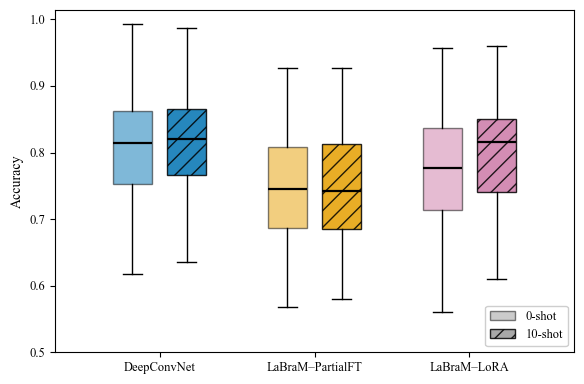

In [30]:
# --- Boxplot: 0-shot vs 10-shot across models (no high/low grouping) ---
from matplotlib.patches import Patch

# Keep only 0 and 10 shots; aggregate per subject × model × shots with MEDIAN across repetitions
df_plot = (
    df_selected[df_selected['shots'].isin([0, 5])]
    .groupby(['subject_id', 'model', 'shots'], as_index=False)['value']
    .median()
)

# Use consistent model order: deepconvnet, labram_last_8 (PartialFT), labram-lora (LoRA)
desired_order = ['deepconvnet', 'labram_last_8', 'labram-lora']
models = [m for m in desired_order if m in df_plot['model'].unique()]

# Prepare grouped data per shot condition
grouped_data = {
    s: [df_plot[(df_plot['model'] == m) & (df_plot['shots'] == s)]['value'].values
        for m in models]
    for s in [0, 5]
}

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=FIGSIZE)

# Common styling
common_medianprops = dict(linewidth=1.6, color='black')
common_boxprops = dict(linewidth=1.0, edgecolor='black')
common_whiskerprops = dict(linewidth=1.0)
common_capprops = dict(linewidth=1.0)

# 0-shot boxes (solid fill, no hatch)
b0 = ax.boxplot(
    grouped_data[0],
    positions=x - width/2,
    widths=0.25,
    patch_artist=True,
    showfliers=False,
    boxprops=common_boxprops,
    medianprops=common_medianprops,
    whiskerprops=common_whiskerprops,
    capprops=common_capprops,
)

# 10-shot boxes (with hatch pattern)
b10 = ax.boxplot(
    grouped_data[5],
    positions=x + width/2,
    widths=0.25,
    patch_artist=True,
    showfliers=False,
    boxprops=common_boxprops,
    medianprops=common_medianprops,
    whiskerprops=common_whiskerprops,
    capprops=common_capprops,
)

# Color boxes by model; 0-shot solid, 10-shot with hatch
for patch, m in zip(b0['boxes'], models):
    patch.set_facecolor(model_colors.get(m, '#cccccc'))
    patch.set_alpha(0.5)
    patch.set_hatch('')  # no hatch for 0-shot

for patch, m in zip(b10['boxes'], models):
    patch.set_facecolor(model_colors.get(m, '#cccccc'))
    patch.set_alpha(0.85)
    patch.set_hatch('//')  # hatch for 10-shot

ax.set_xticks(x)
ax.set_xticklabels([model_name_map.get(m, m) for m in models], rotation=0)
ax.set_ylabel('Accuracy')
ax.set_ylim(0.5, None)  # y-axis starts at 0.5

# Legend (shot distinction only)
handles = [
    Patch(facecolor='0.6', edgecolor='black', alpha=0.5, hatch='', label='0-shot'),
    Patch(facecolor='0.6', edgecolor='black', alpha=0.85, hatch='//', label='10-shot'),
]
ax.legend(handles=handles, loc='lower right', frameon=True, framealpha=0.95)

plt.tight_layout()
plt.savefig('img/boxplot_shots_0_10.jpg', dpi=DPI, bbox_inches='tight')
plt.show()